# Slider Experiment

In [138]:
import csv
import glob
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import pingouin as pg
import scikit_posthocs as ph
import scipy.stats as stats
import seaborn as sns

from collections import OrderedDict
from tabulate import tabulate

sns.set_context("notebook")
sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['patch.linewidth'] = 0.0

palette = sns.color_palette("magma", 4)

# Log parsing code

In [139]:
SHAPE_MOVE_THRESHOLD = 25

class Log:
    def __init__(self, PID, gesture, task, target, block, startTime, endTime, frames=None):
        self.PID = PID
        self.gesture = gesture
        self.task = task
        self.target = target
        self.block = block
        self.startTime = startTime
        self.endTime = endTime
        if frames is None:
            self.frames = []
        else:
            self.frames = frames

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

class Frame:
    def __init__(self, activity, state, cursor_X, cursor_y, slider_position_X, slider_value, message=""):
        self.activity = activity
        self.state = state
        self.cursor_X = cursor_X
        self.cursor_y = cursor_y
        self.slider_position_X = slider_position_X
        self.slider_value = slider_value
        self.message = message

    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

def extract_data(jsonData):
    """
    Parse json into an instance of the Log class.
    """
    frames = []

    for f in jsonData["frames"]:
        frames.append(Frame(f["activity"], f["state"], f["cursor_X"], f["cursor_y"], f["slider_position_X"], f["slider_value"], f["message"] if "message" in f else ""))

    return Log(jsonData["PID"], jsonData["gesture"], jsonData["task"], jsonData["target"], jsonData["block"], jsonData["startTime"], jsonData["endTime"], frames)

def block_success(data: Log):
    """
    Determine task success based on the final slider value.
    """
    return data.frames[-1].slider_value == data.target

def time(data: Log):
    """
    Calculate overall task time and time taken for first land on a target.
    """
    n_frames = 0
    time_start = data.startTime
    time_end = data.endTime
    
    time = time_end - time_start
    time_calculated = False
    
    time_hit = -1
    time_hit_calculated = False
    
    for frame in data.frames:
        n_frames += 1
        ratio = n_frames / float(len(data.frames))
        
        if (not time_calculated) and frame.message.startswith("Transitioning from states NoHands to"):
            time_start = data.startTime + ((time_end - time_start) * ratio)
            time = time_end - time_start
            time_calculated = True
            
            time_hit = time # Set this now as a fallback
        
        if time_calculated and ((frame.slider_value == data.target) or (data.task == "shapeMove" and abs(frame.slider_value - data.target) <= SHAPE_MOVE_THRESHOLD)):
            time_hit = ratio * (time_end - time_start)
            time_hit_calculated = True
        
        if time_calculated and time_hit_calculated:
            break

    if time_hit_calculated:
        return (time, time_hit)
    else:
        return (time, -1)

def overshoots(data: Log):
    """
    Count the number of target overshoots. There are two types of overshoot: going above and
    going below the target value. These are counted when the selected slider value moves over
    the target in a sequence. Might be some bugs with this, e.g., if the slider never perfectly
    sets on the target.
    """
    overList = []
    overCount = 0
    
    # Has crossed to a higher value
    crossed_above = False
    
    # Has crossed to a lower value
    crossed_below = False
    
    for frame in data.frames:
        if frame.slider_value > data.target:
            if not crossed_above:
                crossed_above = True
                crossed_below = False
                
                overCount += 1
                
            overList.append(frame.slider_value)
        else:
            crossed_above = False
            
            if frame.slider_value == data.target:
                crossed_below = True # Not true, but we need to know when we fall off the other side
            else:
                if crossed_below:
                    crossed_below = False
                    
                    overCount += 1
                
                overList.append(frame.slider_value)
            
    return (overList, overCount)

def alphabet_target(letter):
    """
    Calculates the target coordinate for the given letter.
    """
    letters = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
    target_width = 52.30769230769231
    target_offset = letters.index(letter)
    
    return 600.0 + (target_width / 2.0) + (target_width * target_offset)

def digit_target(digit):
    """
    Calculates the target coordinator for the given digit.
    """
    target_width = 136.0
    
    return 600.0 + (target_width / 2.0) + (target_width * digit)

def target_distance(data: Log):
    """
    Calculates the distance in pixels between the target and the final cursor position.
    """
    if len(data.frames) == 0:
        return -1
    
    frame = data.frames[-1]
    
    if data.task == "shapeMove":
        return frame.slider_value - data.target
    elif data.task == "alphaSelector":
        return frame.slider_position_X - alphabet_target(data.target)
    elif data.task == "digitSelector":
        return frame.slider_position_X - digit_target(data.target)
    else:
        return -1

def count_engagements(data: Log):
    """
    Calculates the number of times the user 'engaged' the slider.
    """
    engaged = False
    count = 0
    
    for frame in data.frames:
        if frame.message in ["Transitioning from states NoPinchDetected to PinchDetected", "Transitioning from states NoDwellDetected to DwellDetected"]:
            count += 1
    
    return count

def slider_loc(data: Log):
    """
    Returns the final slider coordinate.
    """
    return ((data.frames[-1].slider_position_X))

# Import log data

In [158]:
columnNames = ["P", "B", "Condition", "Task", "Target", "Selected", "Time", "Time to Target", "Success", "Activations", "Overshoots", "Overshoot_Values", "Location", "ErrorDistance", "AbsErrorDistance"]
data = pd.DataFrame(columns = columnNames)

files = glob.glob("../Logs/*/*/*/*.json")
#files = glob.glob("/Users/kieranwaugh/OneDrive - University of Glasgow/Evaluation_of_Touchless_Scrolling_Interactions/Logs/*/*/*/*.json")
log: Log

# Log files for individual participants can be cached to save regenerating everything
cache_logs = glob.glob("Cache/*.tsv")
use_cache = True

if True:
    for file in files:
        with open(file) as json_file:
            pid = file.split("/")[-4]
            condition = file.split("/")[-2]
            task = file.split("/")[-3]
            
            if use_cache and "Cache/P{}.tsv".format(pid,) in cache_logs:
                continue

            if pid not in ["-1", "1", "2", "3", "4"]:
                log = extract_data(json.load(json_file))

                (task_time, time_to_hit) = time(log)
                success = block_success(log)
                (overshootHits, overshootCount) = overshoots(log)
                activations = count_engagements(log)
                sliderPos = slider_loc(log)
                errorDistance = target_distance(log)

                log_data = pd.DataFrame(columns = columnNames, data = [[pid, log.block, condition, task, log.target, log.frames[-1].slider_value, task_time, time_to_hit, success, activations, overshootCount, set(overshootHits), sliderPos, errorDistance, abs(errorDistance)]])
                data = data.append(log_data)
    
    # Now read in the cached results
    if use_cache:
        for file in cache_logs:
            data_cached = pd.read_csv(file, sep="\t")
            data = pd.concat([data, data_cached], ignore_index=True)
    
    n_total = len(data)
    print("Read {} cached results".format(n_total,))
    
    # Drop task time outliers
    data_filtered = data[data['Time'] <= 30000]
    data_filtered = data_filtered[data_filtered['Time'] > 10]
    
    # Drop tasks where the target was the first cursor point
    data_filtered = data_filtered[data_filtered['Target'] != "A"]
    data_filtered = data_filtered[data_filtered['Target'] != 1]
    
    # Drop tasks with distance outliers
    data_filtered = data_filtered[data_filtered['AbsErrorDistance'] <= 150]

    n_new = len(data)
    n_new_filtered = len(data_filtered)
    print("Read {} new results and kept {} after filtering".format(n_new, n_new_filtered,))
    
    # Write all data to a single file
    data_filtered.to_csv("all_data.tsv", sep="\t")
else:
    data_filtered = pd.read_csv("all_data.tsv", sep="\t")
    
    print("Read {} results".format(len(data_filtered)))
    
# Write individual participant data
for p in data_filtered.P.unique():
    df_p = data_filtered[data_filtered.P == p]
    df_p.to_csv("Cache/P{}.tsv".format(p,), sep="\t")
    

Read 2048 cached results
Read 2048 new results and kept 2038 after filtering


# Summary

In [159]:
print("Read data from {} participants".format(len(data_filtered.P.unique()),))

data_filtered.agg({'Time': ['mean', 'std', 'min', 'max'],
                   'Time to Target': ['mean', 'std', 'min', 'max'],
                   'Overshoots': ['mean', 'std', 'min', 'max'],
                   'Activations': ['mean', 'std', 'min', 'max'],
                   'ErrorDistance': ['mean', 'std', 'min', 'max']})

Read data from 15 participants


,Time,Time to Target,Overshoots,Activations,ErrorDistance
mean,9053.878722,3097.559632,6.643278,27.587831,0.990104
std,5410.773811,3427.291191,5.270292,19.743940,15.453089
min,659.958183,-1.000000,0.000000,2.000000,-147.410000
max,29958.738358,25369.922121,36.000000,174.000000,131.087600


# Exploratory plots

In [160]:
def point_plot(df, dv, iv, n_iv, max_x, xlab="", ylab="", show_grid=False, show_all=True, plot_w=7, plot_h=2, filename=None):
    """
    Creates a point plot showing mean values with 95% confidence intervals.
    
    df: Data frame.
    dv: Column name with the dependent variable measurements.
    iv: Column name with the independent variable values.
    n_iv: Number of levels in the independent variable.
    max_x: Maximum x-axis value.
    show_grid: If True, show a grid in the plot.
    show_all: If True, include a strip plot.
    plot_w: Plot width in inches.
    plot_h: Plot height in inches.
    filename: If given, save to a pdf with this filename.
    """
    plot, axis = plt.subplots(figsize=(plot_w, plot_h))
    
    if show_all:
        sns.stripplot(x=dv, y=iv, hue=iv, data=df, palette=palette, dodge=True, size=6, alpha=0.05, jitter=1.05)
        
    sns.pointplot(x=dv, y=iv, hue=iv, data=df, palette=palette, dodge=.532, join=False, errwidth=1.2, scale=1.5, ci=95)

    # Adjust legend
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles[0:n_iv], labels[0:n_iv], handletextpad=0, columnspacing=1, loc="lower center", ncol=4, frameon=False, bbox_to_anchor=(0.493, 1.0))

    # Adjust axes
    axis.set_ylabel(ylab)
    axis.set_xlabel(xlab)
    axis.set(xlim=(0, max_x))
    axis.yaxis.set_visible(False)
    axis.grid(show_grid)
    
    if show_all:
        axis.margins(x=0.05, y=0.05)

    # Show and save
    plt.show()
    
    if filename is not None:
        plot.savefig(filename, bbox_inches='tight')

## Task time per technique

Plots mean task time per input technique, with 95% confidence intervals.

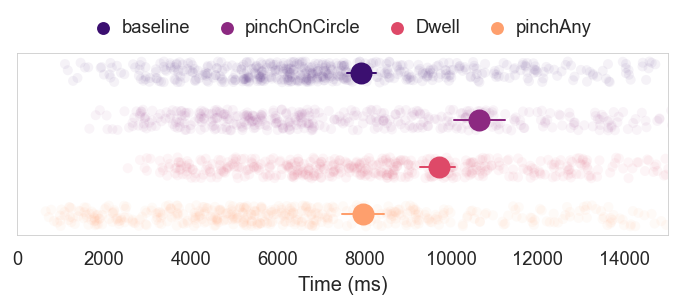

In [161]:
point_plot(data_filtered, "Time", "Condition", 4, 15000, "Time (ms)", plot_w=7, plot_h=2)

## Task time per task type

Plots mean task time per task type, wiht 95% confidence intervals.

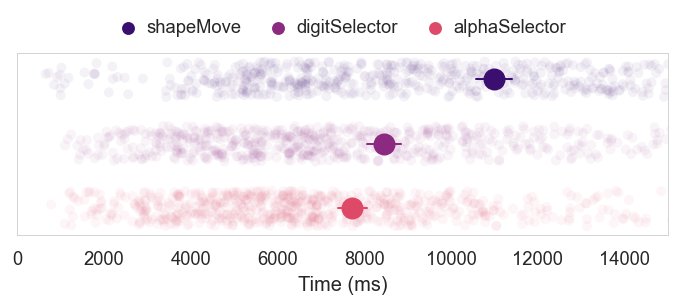

In [162]:
point_plot(data_filtered, "Time", "Task", 3, 15000, "Time (ms)", plot_w=7, plot_h=2)

## Task time for technique x task

Plots the mean task time for each condition and task, with 95% confidence intervals.

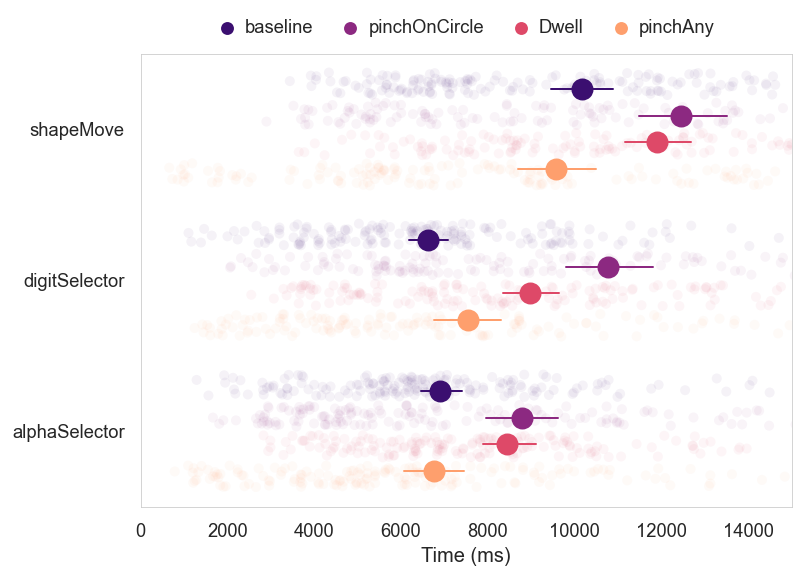

In [163]:
plot, axis = plt.subplots(figsize=(7, 5))

sns.stripplot(x="Time", y="Task", hue="Condition", data=data_filtered, palette=palette, dodge=True, size=6, alpha=0.05, jitter=0.3)
sns.pointplot(x="Time", y="Task", hue="Condition", data=data_filtered, palette=palette, dodge=.532, join=False, errwidth=1.2, scale=1.5, ci=95)

# Adjust legend
handles, labels = axis.get_legend_handles_labels()
axis.legend(handles[0:4], labels[0:4], handletextpad=0, columnspacing=1, loc="lower center", ncol=4, frameon=False, bbox_to_anchor=(0.493, 1.0))

# Adjust axes
axis.set_ylabel("")
axis.set_xlabel("Time (ms)")
axis.set(xlim=(0, 15000))
axis.yaxis.set_visible(True)
axis.grid(False)

# Show and save
plt.show()
#plot.savefig('TaskTimeStrip.pdf', bbox_inches='tight')

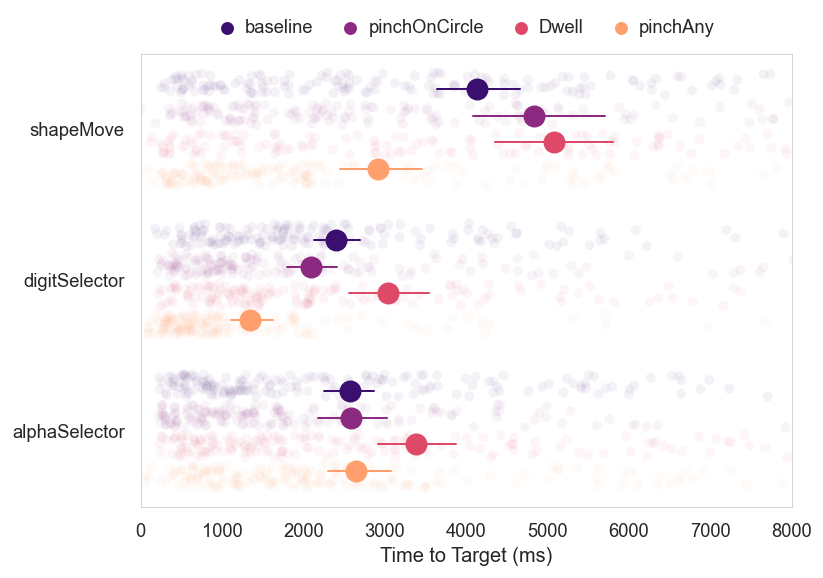

In [165]:
plot, axis = plt.subplots(figsize=(7, 5))

sns.stripplot(x="Time to Target", y="Task", hue="Condition", data=data_filtered, palette=palette, dodge=True, size=6, alpha=0.05, jitter=0.3)
sns.pointplot(x="Time to Target", y="Task", hue="Condition", data=data_filtered, palette=palette, dodge=.532, join=False, errwidth=1.2, scale=1.5, ci=95)

# Adjust legend
handles, labels = axis.get_legend_handles_labels()
axis.legend(handles[0:4], labels[0:4], handletextpad=0, columnspacing=1, loc="lower center", ncol=4, frameon=False, bbox_to_anchor=(0.493, 1.0))

# Adjust axes
axis.set_ylabel("")
axis.set_xlabel("Time to Target (ms)")
axis.set(xlim=(0, 8000))
axis.yaxis.set_visible(True)
axis.grid(False)

# Show and save
plt.show()
#plot.savefig('TaskTimeStrip.pdf', bbox_inches='tight')

## Distance from target

This is the distance in pixels between the final cursor position and the centre of the slider target

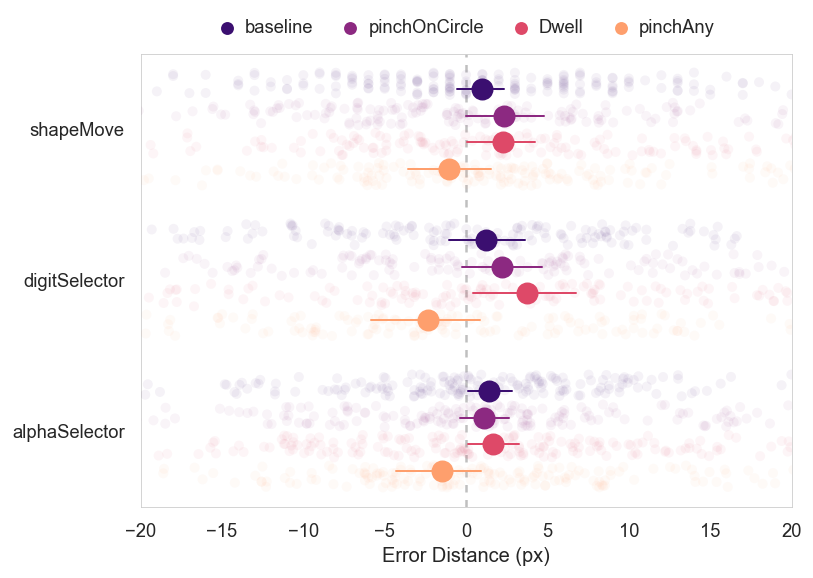

In [174]:
plot, axis = plt.subplots(figsize=(7, 5))

# Add vertical line for distance = 0
plt.axvline(0, 0, 1, dashes=[3, 3], alpha=0.5, color="grey")

sns.stripplot(x="ErrorDistance", y="Task", hue="Condition", data=data_filtered, palette=palette, dodge=True, size=6, alpha=0.05, jitter=0.3)
sns.pointplot(x="ErrorDistance", y="Task", hue="Condition", data=data_filtered, palette=palette, dodge=.532, join=False, errwidth=1.2, scale=1.5, ci=95)

# Adjust legend
handles, labels = axis.get_legend_handles_labels()
axis.legend(handles[0:4], labels[0:4], handletextpad=0, columnspacing=1, loc="lower center", ncol=4, frameon=False, bbox_to_anchor=(0.493, 1.0))

# Adjust axes
axis.set_ylabel("")
axis.set_xlabel("Error Distance (px)")
axis.set(xlim=(-20, 20))
axis.yaxis.set_visible(True)
axis.grid(False)

# Show and save
plt.show()
#plot.savefig('TaskTimeStrip.pdf', bbox_inches='tight')

## Number of target overshoots

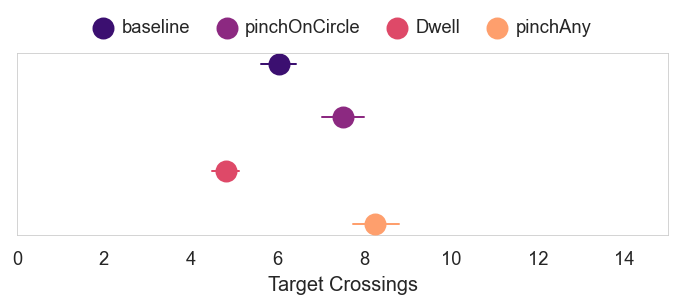

In [175]:
point_plot(data_filtered, "Overshoots", "Condition", 4, 15, "Target Crossings", plot_w=7, plot_h=2, show_all=False)

## Number of cursor activations (i.e., taking control of cursor events)

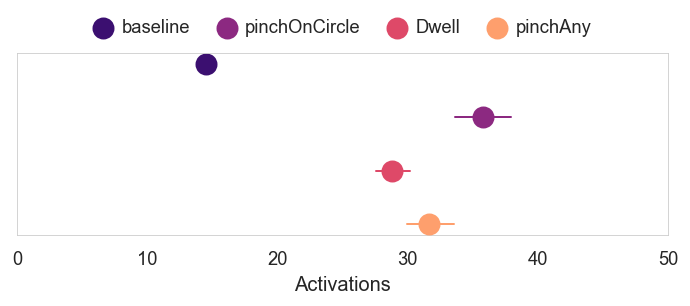

In [176]:
point_plot(data_filtered, "Activations", "Condition", 4, 50, "Activations", plot_w=7, plot_h=2, show_all=False)

# Time to first acquire target

Plots mean time taken for the cursor to first touch the target value. Excludes trials where the target was never directly hit.

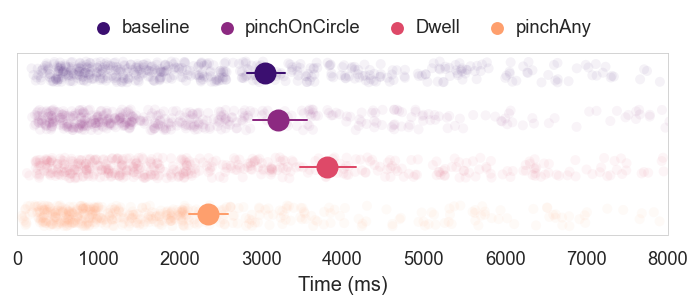

In [177]:
df_hits = data_filtered[data_filtered['Time to Target'] != -1]

point_plot(df_hits, "Time to Target", "Condition", 4, 8000, "Time (ms)", plot_w=7, plot_h=2)

In [ ]:
point_plot(df_hits, "Time to Target", "Task", 3, 8000, "Time (ms)", plot_w=7, plot_h=2)

# Analysis

## Task time

In [184]:
s_w = stats.shapiro(data_filtered["Time"])

if s_w.pvalue <= 0.05:
    print("Task time data does not come from a normal distribution (p = {:.2f}), perform ART in R instead".format(s_w.pvalue,))
else:
    aov_time = pg.rm_anova(dv='Time', within=['Condition', 'Task'], subject='P', data=data_filtered)
    pg.print_table(aov_time)

    print("Remember to ignore comparisons if there is no significant effect!")
    ph_time = pg.pairwise_ttests(dv='Time', within=['Condition', 'Task'], subject='P', marginal=True, effsize="cohen", data=data_filtered)
    pg.print_table(ph_time)

Task time data does not come from a normal distribution (p = 0.00), perform ART in R instead


In [185]:
df_hits = data_filtered[data_filtered['Time to Target'] != -1]

s_w = stats.shapiro(df_hits["Time to Target"])

if s_w.pvalue <= 0.05:
    print("Time to target data does not come from a normal distribution (p = {:.2f}), perform ART in R instead".format(s_w.pvalue,))
else:
    aov_ttt = pg.rm_anova(dv='Time to Target', within=['Condition', 'Task'], subject='P', data=df_hits)
    pg.print_table(aov_ttt)

    print("Remember to ignore comparisons if there is no significant effect!")
    ph_ttt = pg.pairwise_ttests(dv='Time to Target', within=['Condition', 'Task'], subject='P', marginal=True, effsize="cohen", data=df_hits)
    pg.print_table(ph_ttt)

Time to target data does not come from a normal distribution (p = 0.00), perform ART in R instead
